# Crop Yield Prediction: LightGBM with Optuna (Part 5)

## Overview
This notebook trains a **Gradient Boosting Machine (LightGBM)** model to predict crop yields. You can configure the specific target crop in the data loading section.

## Methodology
1.  **Crop Selection:** Choose the specific crop to predict.
2.  **Feature Analysis:** Review the input variables.
3.  **Time-Series Split:** Divide data by year to ensure we don't predict the past using the future:
    * **Train:** Learn patterns.
    * **Validation:** Tune settings.
    * **Test:** Final evaluation.
4.  **Baseline:** Compare against a simple guess (Last Year's Yield).
5.  **Initial Model:** Train a default model and check learning curves for errors.
6.  **Optimization:** Use **Optuna** to automatically find the best model settings.
7.  **Final Evaluation:** Compare accuracy (RMSE) across all stages.

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

C:\Users\PavinP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Preparation and Crop Choice
We load the main dataset and identify the available crops. For this analysis, we focus specifically on **Rice**. We clean the data by removing columns related to other crops and deleting any rows where the target yield information is missing.

In [3]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v2.parquet')

# --- LIST AVAILABLE CROPS ---
# Assumes targets start with 'Y_'
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'  # <--- CHANGE THIS to 'lettuce', 'pepper', etc. based on list above
# ------------------------------------

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")
print(f"Using Lag 1 Feature: {LAG_1_FEATURE}")

# Clean Missing Targets for the chosen crop
df_model = df.dropna(subset=[TARGET_COL])

print(f"Data Loaded. Rows with valid target: {len(df_model)}")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Using Lag 1 Feature: avg_yield_rice_1y
Data Loaded. Rows with valid target: 4729


### 2. Selecting Features and Splitting Data
We identify the input variables (features), such as weather data and previous years' yields. To prevent the model from "cheating" by seeing the future, we split the data based on time:
* **Training Data:** Years before 2014.
* **Validation Data:** Years 2014 to 2018.
* **Test Data:** Years 2019 and later.

In [4]:
# --- DROP UNWANTED COLUMNS ---
# Drop all columns that start with "avg_yield_" but do NOT match the chosen crop
# Example: If predicting Rice, we drop 'avg_yield_lettuce_1y', etc.
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# 1. Training Set (< 2014)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (>= 2014 and < 2019) -> This covers 2014 to 2018
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2019)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTraining Samples   (<{TRAIN_END_YEAR})     : {len(X_train)}")
# Subtract 1 here to show the inclusive range (2014-2018)
print(f"Validation Samples ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1}): {len(X_val)}")
print(f"Testing Samples    (>={VAL_END_YEAR})    : {len(X_test)}")


Total Features Used: 23
------------------------------


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_3y,avg_yield_rice_5y,sum_rain_winter,sum_rain_spring,sum_rain_summer,sum_rain_autumn,sum_rain_annual,avg_solar_winter,...,avg_solar_annual,avg_temp_winter,avg_temp_spring,avg_temp_summer,avg_temp_autumn,avg_temp_annual,pesticides_lag1,fertilizer_lag1,latitude,longitude



Training Samples   (<2014)     : 3579
Validation Samples (2014-2018): 575
Testing Samples    (>=2019)    : 575


In [5]:
X_train.head()

,year,avg_yield_rice_1y,avg_yield_rice_3y,avg_yield_rice_5y,sum_rain_winter,sum_rain_spring,sum_rain_summer,sum_rain_autumn,sum_rain_annual,avg_solar_winter,...,avg_solar_annual,avg_temp_winter,avg_temp_spring,avg_temp_summer,avg_temp_autumn,avg_temp_annual,pesticides_lag1,fertilizer_lag1,latitude,longitude
0,1982,2241.4,2181.766667,2097.64,150.63,113.69,34.44,26.56,325.32,NaN,...,NaN,0.880000,12.286667,21.830000,11.800000,11.699167,NaN,5.778887,34.53,69.17
1,1983,2199.4,2204.533333,2156.56,139.74,172.94,3.65,57.21,373.54,NaN,...,NaN,-0.713333,9.976667,21.856667,11.483333,10.650833,NaN,6.672946,34.53,69.17
2,1984,2258.1,2232.966667,2200.56,60.60,202.73,9.34,0.58,273.25,NaN,...,NaN,0.953333,9.246667,22.393333,12.940000,11.383333,NaN,7.152971,34.53,69.17
3,1985,2241.6,2233.033333,2222.66,68.62,89.17,17.24,21.07,196.10,11.200000,...,19.215833,-1.406667,13.023333,24.120000,11.816667,11.888333,NaN,9.178255,34.53,69.17
4,1986,2248.2,2249.300000,2237.74,75.65,65.67,5.44,8.33,155.09,11.366667,...,18.741667,1.843333,12.990000,22.946667,12.266667,12.511667,NaN,9.224020,34.53,69.17


### 3. Setting a Baseline
Before using complex AI, we create a simple baseline to measure success. We assume that the yield this year will be exactly the same as last year. We calculate the error (RMSE) of this simple guess to establish a score we must beat.

In [6]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = X_test[LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
y_test_clean = y_test[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 533.44


### 4. Initial Model Testing
We train a basic LightGBM model using default settings. We plot a learning curve to ensure the model is learning patterns rather than just memorizing data (overfitting). We then calculate the initial accuracy on the Test set to see how it compares to the baseline.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5375
[LightGBM] [Info] Number of data points in the train set: 3579, number of used features: 23
[LightGBM] [Info] Start training from score 3365.356527
Training until validation scores don't improve for 50 rounds
[100]	Train's rmse: 363.947	Train's l2: 132457	Validation's rmse: 513.581	Validation's l2: 263765
Early stopping, best iteration is:
[96]	Train's rmse: 368.141	Train's l2: 135528	Validation's rmse: 512.693	Validation's l2: 262854


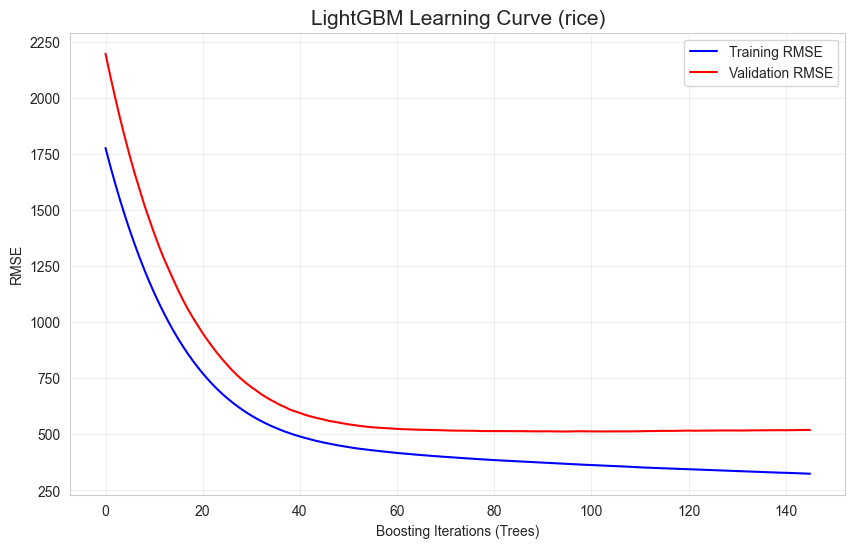

Initial Model Test RMSE: 522.58


In [7]:
# --- INITIAL MODEL TRAINING ---

# 1. Initialize LightGBM
model_init = lgb.LGBMRegressor( 
    n_estimators=1000, 
    learning_rate=0.05, 
    num_leaves=31, 
    random_state=42, 
    n_jobs=-1 
)

# 2. Dictionary to store training metrics for plotting
evals_result = {}

# 3. Train on TRAIN, Early Stop on VALIDATION
model_init.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_names=['Train', 'Validation'],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
        lgb.record_evaluation(evals_result)
    ]
)

# --- PLOT LEARNING CURVE (RMSE over Iterations) ---
def plot_learning_curve(evals_result, metric='rmse'):
    plt.figure(figsize=(10, 6))
    
    train_metric = evals_result['Train'][metric]
    val_metric = evals_result['Validation'][metric]
    
    plt.plot(train_metric, label='Training RMSE', color='blue')
    plt.plot(val_metric, label='Validation RMSE', color='red')
    
    plt.title(f'LightGBM Learning Curve ({CHOSEN_CROP})', fontsize=15)
    plt.xlabel('Boosting Iterations (Trees)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(evals_result)

# Evaluate on TEST Set
y_pred_init_test = model_init.predict(X_test)
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)

print(f"Initial Model Test RMSE: {rmse_init_test:.2f}")

### 5. Tuning the Model (Optuna)
To improve performance, we use **Optuna** to find the best model settings (hyperparameters). We run 50 different trials, adjusting settings like learning rate and tree depth, to minimize the error on the validation data.

In [8]:
# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.6),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# --- RUN OPTIMIZATION ---
study_name = f'{CHOSEN_CROP.capitalize()}_Yield_LGBM'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=50)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-29 18:56:14,342] A new study created in memory with name: Rice_Yield_LGBM
[I 2025-11-29 18:56:14,413] Trial 0 finished with value: 532.8063669421607 and parameters: {'learning_rate': 0.09296967221929112, 'num_leaves': 42, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.9145202905408301, 'colsample_bytree': 0.5194333912440184, 'reg_alpha': 0.8606437032959681, 'reg_lambda': 0.0016301085307413288}. Best is trial 0 with value: 532.8063669421607.
[I 2025-11-29 18:56:14,447] Trial 1 finished with value: 526.5607637405017 and parameters: {'learning_rate': 0.08913646361282791, 'num_leaves': 89, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9007861864250601, 'colsample_bytree': 0.48271733642337306, 'reg_alpha': 8.866534895284705e-08, 'reg_lambda': 2.589009908437612e-08}. Best is trial 1 with value: 526.5607637405017.
[I 2025-11-29 18:56:14,521] Trial 2 finished with value: 545.4348852153485 and parameters: {'learning_rate': 0.04432185125344854, 'num_leaves': 41, 'ma


Best Parameters found:
{'learning_rate': 0.017383151328959623, 'num_leaves': 59, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.7731059433937311, 'colsample_bytree': 0.4997898388966592, 'reg_alpha': 2.7884685712470017e-05, 'reg_lambda': 0.002254375783489423}


### 6. Visualizing Optimization
We generate charts to understand the tuning process. These visual tools show us which specific settings had the biggest impact on reducing the model's error and how the optimization improved over time.

In [9]:
# --- OPTUNA VISUALIZATIONS ---
name = f"{CHOSEN_CROP.capitalize()}_Yield_Model"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
# fig.write_image(f'optuna_{name}_history.png') # Optional save
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
# fig.write_image(f'optuna_{name}_parallel_coordinate.png')
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
# fig.write_image(f'optuna_{name}_slice.png')
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    # fig.write_image(f'optuna_{name}_param_importance.png')
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Final Model Training
Using the best settings found during the tuning phase, we build the final model. We train this model on both the Training and Validation data combined to maximize the information available for learning.

In [10]:
# 1. Combine Train + Validation for Final Training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# 2. Initialize with Best Params
best_params = study.best_params
best_params['n_estimators'] = 1000
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = lgb.LGBMRegressor(**best_params)

# 3. Train on Full History
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# 4. Final Prediction on TEST Data
y_pred_final_test = final_model.predict(X_test)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[438]	training's rmse: 460.921	training's l2: 212448	valid_1's rmse: 492.165	valid_1's l2: 242227


### 8. Results and Analysis
We evaluate the final performance on the Test data (2019–2023).


* **Comparison:** We check if the Tuned Model beats the Baseline and the Initial Model.


--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=533.44, R2=0.9427
Initial Model:  RMSE=522.58, R2=0.9451
Tuned Model:    RMSE=492.17, R2=0.9513 (RMSE Improved 7.74%)


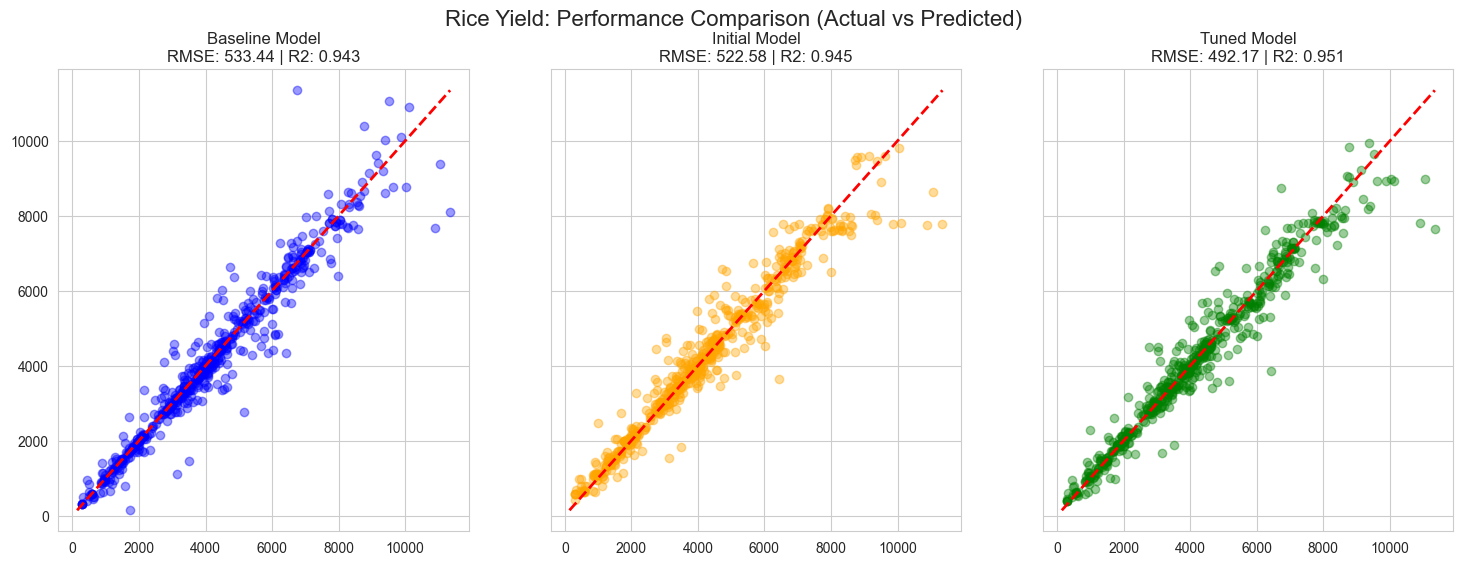

In [11]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model:  RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned Model:    RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Axis Limits
all_preds = np.concatenate([y_pred_clean, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test_clean, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline Model\nRMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.3f}')

# 2. Initial Model Plot
axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial Model\nRMSE: {rmse_init_test:.2f} | R2: {r2_init_test:.3f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned Model\nRMSE: {rmse_final_test:.2f} | R2: {r2_final_test:.3f}')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Performance Comparison (Actual vs Predicted)', fontsize=16)
plt.show()

* **Trend Analysis:** We plot the predicted yields against actual yields over time to visualize accuracy.


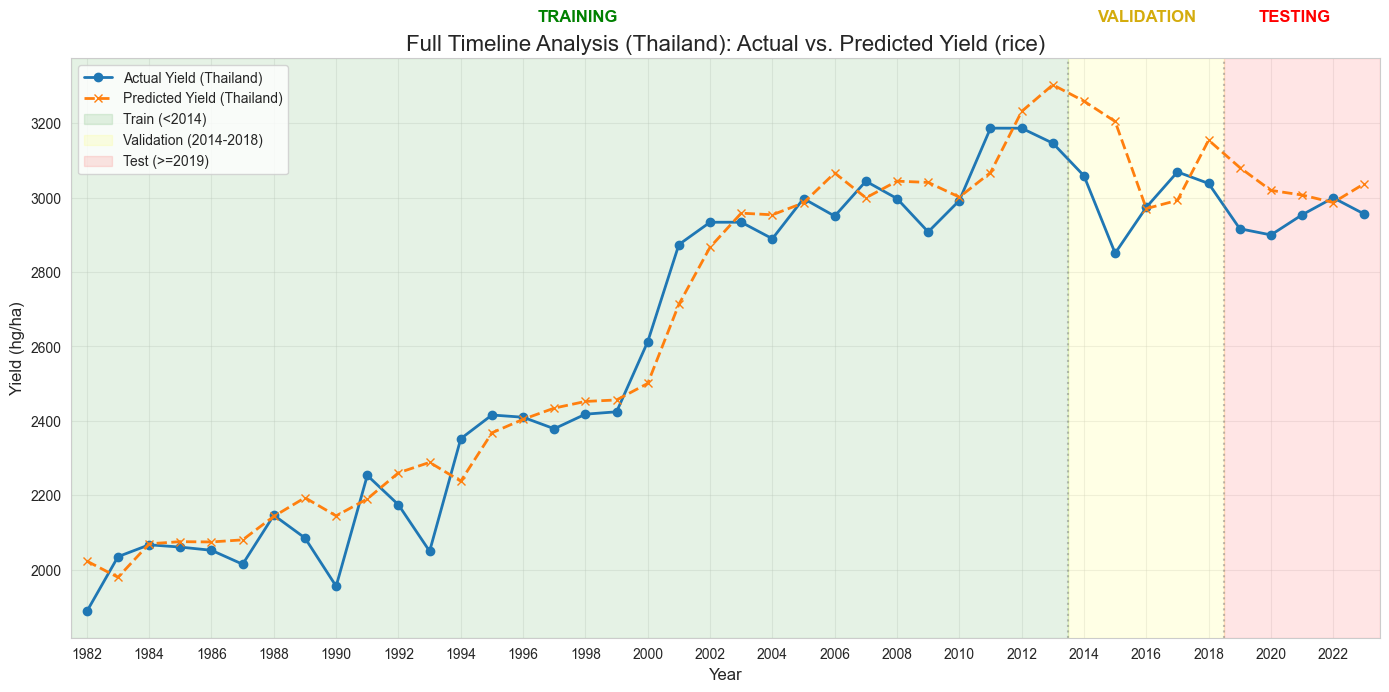

In [16]:
import matplotlib.pyplot as plt

# Ensure these match your previous variables
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# Country parameter
TARGET_COUNTRY = "Thailand"

# 1. Generate Predictions
all_predictions = final_model.predict(df_model[feature_cols])

# 2. Create DataFrame WITH AREA column
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Area': df_model['area'],      # added so we can filter by country
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})

# ❗ 3. Filter for Thailand only
df_th = df_full_trend[df_full_trend['Area'] == TARGET_COUNTRY]

# Aggregate by Year
yearly_trend = df_th.groupby('Year')[['Actual', 'Predicted']].mean()

# 3. Plotting
plt.figure(figsize=(14, 7))

# Plot Lines
plt.plot(yearly_trend.index, yearly_trend['Actual'], 
         marker='o', label=f'Actual Yield ({TARGET_COUNTRY})', linewidth=2)
plt.plot(yearly_trend.index, yearly_trend['Predicted'], 
         marker='x', linestyle='--', label=f'Predicted Yield ({TARGET_COUNTRY})', linewidth=2)

# Define Split Boundaries
MIN_YEAR = yearly_trend.index.min()
MAX_YEAR = yearly_trend.index.max()

# CALCULATE OFFSETS
train_boundary = TRAIN_END_YEAR - 0.5
val_boundary   = VAL_END_YEAR - 0.5

# Highlight Periods
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1, 
            label=f'Train (<{TRAIN_END_YEAR})')
plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, 
            label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1})')
plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1, 
            label=f'Test (>={VAL_END_YEAR})')

# Add Vertical Lines
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# Add Text Labels
y_max = yearly_trend['Actual'].max()
text_y = y_max * 1.09 

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING', 
         ha='center', fontsize=12, fontweight='bold', color='green')
plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION', 
         ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')
plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING', 
         ha='center', fontsize=12, fontweight='bold', color='red')

# Final Formatting
plt.title(f'Full Timeline Analysis ({TARGET_COUNTRY}): Actual vs. Predicted Yield ({CHOSEN_CROP})',
          fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Force x-axis to show integer years
plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

plt.tight_layout()
plt.show()


* **Geographic Error:** We map the error rates by country to see where the model performs best and where it struggles.

In [13]:


# --- REFRESHING THE TEST DATA CONTEXT ---
# 3. Test Set (>= 2019)
VAL_END_YEAR = 2019
mask_test = df_model['year'] >= VAL_END_YEAR

# We need the original 'area' column from the test set for joining
# We can also grab 'year' for context
test_set_context = df_model[mask_test][['area', 'year']] 

# --- RE-CREATE COMPARISON DF WITH FEATURE JOINED ---

# 1. Create the Comparison DataFrame (as before)
comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_final_test
})

# 2. Join the desired feature column(s) from the test set
# The join works automatically because y_test (and comparison_df) retained 
# the index from the original df_model[mask_test].
comparison_df = comparison_df.join(test_set_context)

# 3. Reorder the columns for better readability (optional)
comparison_df = comparison_df[['year', 'area', 'Actual_Value', 'Predicted_Value']]

# 4. Display the header
print("--- Actual vs. Predicted Test Set Results with Feature Context ---")
print(comparison_df.head())

--- Actual vs. Predicted Test Set Results with Feature Context ---
    year         area  Actual_Value  Predicted_Value
37  2019  Afghanistan        4476.6      4574.910139
38  2020  Afghanistan        4441.7      4572.007445
39  2021  Afghanistan        4406.5      4584.620759
40  2022  Afghanistan        4625.0      4521.840986
41  2023  Afghanistan        4627.9      4611.957712


In [14]:
import plotly.express as px

# Assuming comparison_df is defined and country names are cleaned up here...
comparison_df['area'] = comparison_df['area'].replace({
    'United_States_of_America': 'United States',
    'United_Kingdom_of_Great_Britain_and_Northern_Ireland': 'United Kingdom',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'Bolivia_(Plurinational_State_of)': 'Bolivia',
    'Iran_(Islamic_Republic_of)': 'Iran',
    "Lao_People's_Democratic_Republic": 'Laos',
    'China,_mainland': 'China',
    'China,_Taiwan_Province_of': 'Taiwan',
    "Democratic_People's_Republic_of_Korea": 'North Korea',
    'Republic_of_Korea': 'South Korea',
    'Côte_d\'Ivoire': "Cote d'Ivoire",
    'United_Republic_of_Tanzania': 'Tanzania',
    'Micronesia_(Federated_States_of)': 'Micronesia',
    'Venezuela_(Bolivarian_Republic_of)': 'Venezuela'
})

def plot_geographic_error(comparison_df):
    """
    Aggregates prediction RMSPE and RMSE by country and plots the distribution 
    on a world map using Plotly Express, with both metrics in the hover data.
    """

    # --- 1. Compute Errors ---
    
    # Squared Error (for RMSE)
    comparison_df['Squared_Error'] = (
        comparison_df['Actual_Value'] - comparison_df['Predicted_Value']
    ) ** 2

    # Squared Percentage Error (for RMSPE)
    epsilon = 1e-6 
    comparison_df['Squared_Percentage_Error'] = (
        (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / 
        (comparison_df['Actual_Value'] + epsilon)
    ) ** 2

    # --- 2. Aggregate Errors by Country ---
    
    # Calculate RMSE
    rmse_df = (
        comparison_df.groupby('area')['Squared_Error']
        .mean()
        .apply(np.sqrt)
        .reset_index()
        .rename(columns={'area': 'Country', 'Squared_Error': 'RMSE'})
    )
    
    # Calculate RMSPE
    rmspe_df = (
        comparison_df.groupby('area')['Squared_Percentage_Error']
        .mean()
        .apply(np.sqrt)
        .multiply(100)
        .reset_index()
        .rename(columns={'area': 'Country', 'Squared_Percentage_Error': 'RMSPE'})
    )

    # 3. Compute mean Actual & Predicted per Country (for hover display)
    ap_df = comparison_df.groupby('area')[['Actual_Value', 'Predicted_Value']].mean().reset_index()
    ap_df = ap_df.rename(columns={'area': 'Country'})

    # 4. Merge RMSPE, RMSE, Actual, and Predicted
    error_stats = rmspe_df.merge(rmse_df, on='Country', how='left') # Merge RMSPE and RMSE
    error_stats = error_stats.merge(ap_df, on='Country', how='left') # Merge with Actual/Predicted

    # 5. Choropleth Map with hover info (Now includes RMSE)
    fig = px.choropleth(
        error_stats,
        locations='Country',
        color='RMSPE',
        locationmode='country names',
        color_continuous_scale=['green', 'red'], 
        range_color=[0, 50], 
        title='Geographic Distribution of Prediction Error (RMSPE)',
        labels={'RMSPE': 'RMSPE (%)'},
        hover_name='Country',
        hover_data={
            'RMSPE': ':.2f',
            'RMSE': ':.2f', # <-- ADDED RMSE HERE
            'Actual_Value': ':.2f',
            'Predicted_Value': ':.2f',
        },
        projection='natural earth'
    )

    # 6. Layout adjustments
    fig.update_layout(
        title_font_size=18,
        coloraxis_colorbar=dict(
            title='RMSPE (%)',
            orientation='h',
            len=0.5,
            yanchor='bottom',
            y=-0.12
        ),
        geo=dict(
            showframe=False,
            showcoastlines=True,
            showcountries=True,
            countrycolor='black',
            bgcolor='lightgrey'
        )
    )

    fig.show()

# Run updated visualization
# plot_geographic_error(comparison_df)
    
# Run updated visualization
plot_geographic_error(comparison_df) # Don't run this, as comparison_df is not available here.

C:\Users\PavinP\AppData\Local\Temp\ipykernel_14976\1929417584.py:73: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### 9. Key Factors (Feature Importance)
Finally, we analyze what drives the predictions. We list the top 20 features that influence rice yield. Typically, the most important factors are previous yields (history) and specific climate metrics like temperature and solar radiation.


--- Top 20 Most Important Features (Text Report) ---
              Feature  Importance (Gain)
0   avg_yield_rice_1y       2.013080e+11
1   avg_yield_rice_3y       1.161454e+11
2   avg_yield_rice_5y       6.328179e+10
3     fertilizer_lag1       1.019801e+10
4     avg_temp_winter       8.142059e+09
5            latitude       6.341575e+09
6     avg_temp_spring       3.809010e+09
7    avg_solar_winter       2.752942e+09
8    avg_solar_annual       1.980293e+09
9     pesticides_lag1       1.650157e+09
10          longitude       1.557558e+09
11    avg_temp_summer       9.599707e+08
12   avg_solar_autumn       8.982757e+08
13    sum_rain_annual       6.336010e+08
14    sum_rain_spring       5.619498e+08
15    sum_rain_winter       5.190064e+08
16    avg_temp_autumn       4.664689e+08
17   avg_solar_spring       4.593685e+08
18               year       4.563008e+08
19    sum_rain_autumn       1.788002e+08


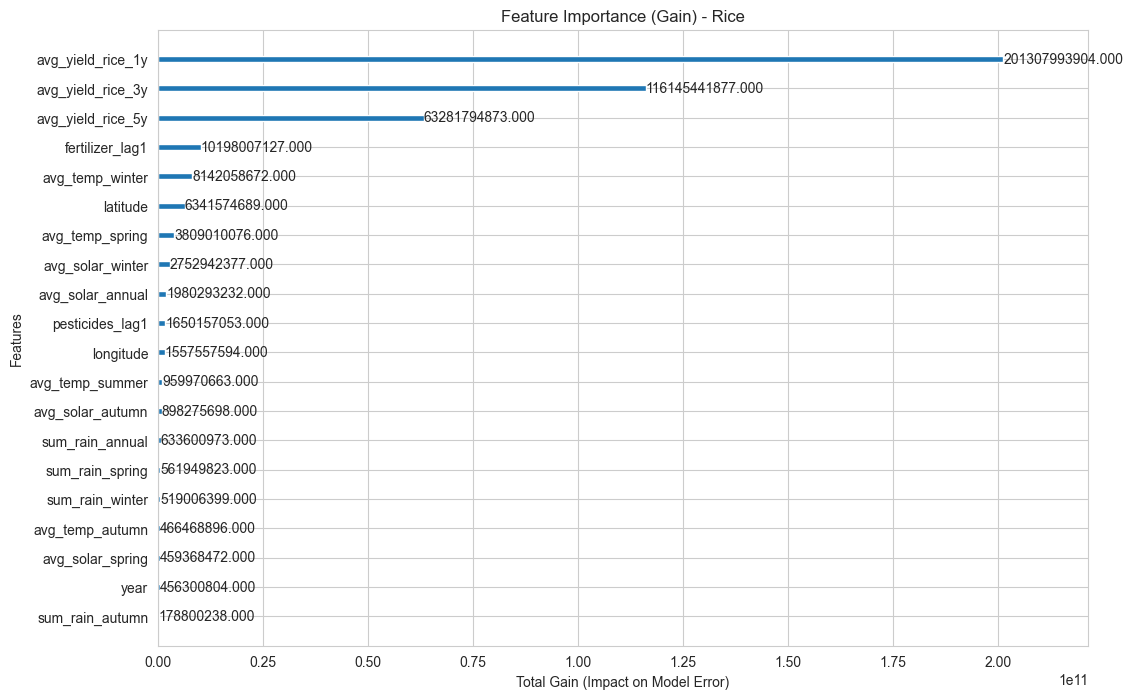

In [15]:
# --- FEATURE IMPORTANCE: PLOT & TEXT ---

# 1. Extract feature importances (using 'gain' for accuracy contribution)
importances = final_model.booster_.feature_importance(importance_type='gain')
feature_names = final_model.feature_name_

# 2. Create a DataFrame to display as text
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Gain)': importances
})

# 3. Sort by importance
fi_df = fi_df.sort_values(by='Importance (Gain)', ascending=False).reset_index(drop=True)

# 4. PRINT TEXT: Display the Top 20 features
print("\n--- Top 20 Most Important Features (Text Report) ---")
print(fi_df.head(20))

# 5. PLOT GRAPH: Use LightGBM's built-in plotter
lgb.plot_importance(
    final_model, 
    max_num_features=20, 
    importance_type='gain', 
    figsize=(12, 8), 
    title=f'Feature Importance (Gain) - {CHOSEN_CROP.capitalize()}',
    xlabel='Total Gain (Impact on Model Error)'
)
plt.show()